# COMP4187: Parallel Scientific Computing II

## Anne Reinarz
## anne.k.reinarz@durham.ac.uk

# Organisation

- In term 1 lectures take place at 12:00 on Wednesdays in CM107. 
- Recordings of each lecture will be uploaded on encore
- Starting term 2, the course will be taken over by Lawrence Mitchell

# Organisation

# Discussion forum 

- We have set up a discussion forum where you can ask, and answer, questions. 
- You’ll need a GitHub account to use it.
- Note that this repository and forum is publically visible.
- You will need aforementioned github account to submit the coursework as well


# Office hours 
- We’re happy to answer any questions in office hours, email to arrange a time.

# Numerical Methods (Term 1) 

- Time dependent PDEs. Stability constraints for time-dependent PDEs, connection to eigenvalue analysis;
- Spatial discretisation. Finite difference methods for partial differential equations (PDEs), stability, convergence, and consistency;
- Implicit ordinary differential equation (ODE) methods, and matrix representations of PDE operators;
- Advanced algorithms for PDEs. Fast methods of solving PDEs, high order discretisation schemes.



# Parallel Computing (Term 2) 

- Distributed memory programming models: MPI.

- Parallel algorithms and data structures for finite difference codes.

- Irregular data distribution and load-balancing.

- Measurement and modelling. Analysis of achieved performance, performance models, including the Roofline model.

# Organisation

# Reading

- LeVeque, Finite Difference Methods for Ordinary and Partial Differential Equations, SIAM (2007).

- Some of this material is taken from [Jed Brown's](https://jedbrown.org) numerical computation course https://github.com/cucs-numcomp/numcomp-class/, licensed under BSD 2-clause.


- A readable textbook that covers this material (with more rigour than in this course, but still easy to follow) is Arieh Iserles' [*A first course in the numerical analysis of differential equations*](http://www.damtp.cam.ac.uk/user/ai/Arieh_Iserles/Textbook.html). Our treatment will be somewhat more computational.

# Coursework


- Coursework 1

  -  Deadline: 2pm on 3rd November 2011
  -  Submission: github classroom, link will be provided
  -  20% of mark


- Coursework 2

  -  Deadline: 2pm on 11 May 2022
  -  Submission: github classroom, link will be provided
  -  80% of mark

# Introduction and overview

Each lecture has a corresponding [Jupyter](https://jupyter.org) notebook, which you can execute. I recommend using something like the following:

```shell
$ python3 -m venv scicomp
$ . scicomp/bin/activate # for bash shells, other activation scripts are available
$ pip install matplotlib jupyter ipython numpy scipy
```

Each of the notebooks will be linked under "Lectures: Numerics" as we work through them 

# Introduction and overview

In addition to thinking about discretising in time (ODEs) we will also look at discretising differential equations in space (PDEs), and the interplay between them.

We'll start by recapitulating some of the terminology and results from CMIII, in particular stability and consistency of numerical methods for ODEs.



## Discretising an ODE

### Method of lines

When we eventually encounter spatial derivatives, along with time derivatives, we will first discretise in space, obtaining a system of ODEs and then in time. This is known as the _method of lines_. For now, we will just assume that we have already discretised in space to obtain the ODE system

$$
 \dot u = f(t, u), t \ge t_0, u(t_0) = u_0
$$

where $f : [t_0, \infty) \times \mathbb{R}^d \to \mathbb{R}^d$, $u \in \mathbb{R}^d$ and we require that $f$ is sufficiently "nice".


## Discretising an ODE

### Method of lines

We will at the very least, require that $f$ is Lipschitz:

$$
\| f(t, x) - f(t, y) \| \le \lambda \| x - y \| \text{ for all } x, y \in \mathbb{R}^d, t \ge t_0,
$$

where $\lambda > 0$ is the _Lipschitz constant_. Informally, this says that we can bound the difference in the output of $f$ for two values by the difference of the values.

Sometimes we will want $f$ to be analytic (so that we can perform Taylor expansions).

This is a _first order_ ODE, since there is only one time derivative.

## Discretising an ODE

#### Uniqueness

If the Lipschitz condition is satisfied, one can prove that the ODE system has a unique solution.

We will call $u^*(t)$ a _solution_ to $\dot u = f(t, u)$, if, for all $t$

$$
\dot u^*(t) = f(t, u^*(t)).
$$

We note, and are not the first, that this solution usually contains a free parameter, so that for uniqueness we need to specify an _initial value_ $u(0) = u_0$. Such problems are therefore termed _initial value problems_ or IVPs.

## Discretising the $\dot u$ term

### Explicit Euler

We can formally write down the solution to our ODE problem by integrating the RHS:

$$
u(t) = u(t_0) + \int_{t_0}^t f(\tau, u(\tau)) \text{d}\tau.
$$

We can _approximate_ the integral using linear interpolation by making the approximation $f(t, u(t)) \approx f(t_0, u(t_0))$ for $t \in [t_0, t_0 + h]$ with $h > 0$ sufficiently small.


## Discretising the $\dot u$ term

### Explicit Euler

writing $u_n$ as the numerical estimate of the solution at $u(t_n)$ we obtain the explicit (or forward) Euler method:

$$
u_{n+1} = u_n + h f(t_n, u_n).
$$


## Discretising the $\dot u$ term

### Explicit Euler

Let's look at how this behaves for a sample problem (this problem is *stiff*, a property we will return to later)

$$
\dot u = -k(u - \cos{t})
$$

For an initial value $u(0) = u_0$, this problem has exact solution

$$
u(t) = \frac{k}{1+k^2}(\sin{t} + k \cos{t}) + \left(u_0 - \frac{k^2}{1+k^2}\right) \exp{(-kt)}.
$$



Let's go ahead and integrate this equation numerically

In [ ]:
%matplotlib notebook
import numpy
from matplotlib import pyplot
pyplot.style.use("ggplot")

class f(object):
    def __init__(self, k):
        self.k = k
    
    def __call__(self, t, u):
        return -self.k * (u - numpy.cos(t))
    
    def __str__(self):
        return "f(k={})".format(self.k)

    def exact(self, t, u_0):
        k = self.k
        k2p1 = k/(1 + k**2)
        return (u_0 - k*k2p1)*numpy.exp(-k*t) + k2p1 * (numpy.sin(t) + k*numpy.cos(t))
    
def ode_euler(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    if isinstance(f, numpy.ndarray):
        f_ = f
        # Hack for linear problems
        f = lambda t_, u_: f_ @ u_
    while t < T:
        h = min(h, T - t)
        u = u + h * f(t, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

u_0 = numpy.array(0.2)

pyplot.figure()

for k in [200]:
    rhs = f(k)
    thist, uhist = ode_euler(rhs, u_0, h=.01, T=12)
    pyplot.plot(thist, uhist, "o", linestyle="solid", label=str(rhs)+' Forward Euler')
    pyplot.plot(thist, rhs.exact(thist, u_0), label=str(rhs)+' exact')
pyplot.legend(bbox_to_anchor=(0.5, 1), loc='center', ncol=2);

This looks pretty good in the eyeball norm.

#### Questions

1. What happens when you increase $k$ further?
2. What about if you try and increase $h$?

## Convergence of a method

A timestepping method is _convergent_ if, as we take the timestep $h \to 0$, the numerical solution tends to the exact solution. Formally, we require for a time interval $[t_0, t_0 + t^*]$ that

$$
\lim_{h \to 0^+} \max_{n} \| u_{n, h} - u(t_n) \| = 0 \text{ for all } t^* > 0,
$$
where the maximum is taken over all timesteps, $h$ denotes the step size, and $u(t_n)$ denotes the exact solution at time $t_n$.



### Is explicit Euler convergent?

Let's check. Write $e_{n, h} := u_{n, h} - u(t_n)$ for the numerical error. Write $t_{n+1} = t_n + h$ and Taylor expand $u$ around $t_n$:


### Is explicit Euler convergent?

Let's check. Write $e_{n, h} := u_{n, h} - u(t_n)$ for the numerical error. Write $t_{n+1} = t_n + h$ and Taylor expand $u$ around $t_n$:

Recall Taylor sequence of f around $a$:
$$f(x) = f(a)+\frac {f'(a)}{1!} (x-a)+ \frac{f''(a)}{2!} (x-a)^2+\frac{f'''(a)}{3!}(x-a)^3+ \cdots$$

### Is explicit Euler convergent?

Let's check. Write $e_{n, h} := u_{n, h} - u(t_n)$ for the numerical error. Write $t_{n+1} = t_n + h$ and Taylor expand $u$ around $t_n$:

$$
u(t_{n+1}) = u(t_n) + h \dot u(t_n) + \mathcal{O}(h^2).
$$

Now substitute in the definition of $\dot u$ to obtain

$$
u(t_{n+1}) = u(t_n) + h f(t, u(t_n)) + \mathcal{O}(h^2)
$$


### Is explicit Euler convergent?


Subtract this from the numerical $u_{n+1}$ obtained from the Euler formula to obtain

$$
e_{n+1, h} = e_{n, h} + h[f(t, \underbrace{u(t_n) + e_{n, h}}_{u_n}) - f(t, u(t_n))] + \mathcal{O}(h^2)
$$

We're interested in bounding the size of this error, so let's take norms of both sides

$$
\|e_{n+1, h}\| = \|e_{n, h} + h[f(t, u(t_n) + e_{n, h}) - f(t, u(t_n))] + \mathcal{O}(h^2)\|
$$


### Is explicit Euler convergent?

Now use the triangle inequality

$$
\|a + b\| \le \|a\| + \|b\|
$$

to split the term on the right hand side, and use the Lipschitz condition

$$
\begin{align}
\|e_{n+1, h}\| &\le \|e_{n, h}\| + h\|[f(t, u(t_n) + e_{n, h}) - f(t, u(t_n))]\| + \|\mathcal{O}(h^2)\|\\
&\le (1 + h\lambda)\|e_{n,h}\| + \mathcal{O}(h^2) = (1 + h\lambda)\|e_{n,h}\| + c h^2
\end{align}
$$



### Is explicit Euler convergent?

By induction on $n$

$$
\|e_{n, h}\| \le \frac{c}{\lambda} h [(1 + h\lambda)^n - 1], n = 0, 1, \dots
$$

Finally we have $(1 + h\lambda) < e^{h\lambda}$ (hint: taylor expand exponential and note that both $h$ and $\lambda$ are positive) and so $(1 + h\lambda)^n < e^{nh\lambda}$. Since $n$ indexes the time interval, $\max_n = \lfloor t^* / h \rfloor$ and so $e^{nh\lambda} < e^{\lfloor t^*/h \rfloor h \lambda} \le e^{t^*\lambda}$. 


### Is explicit Euler convergent?
Hence

$$
\|e_{n, h}\| \le \frac{c}{\lambda} h (e^{t^* \lambda} -1),
$$

which converges to zero as $h \to 0$.

#### Observations

It is tempting to use this to provide an upper bound on the error of the method, however, the bound is not at all sharp (typically overestimating the error by many orders of magnitude).



#### Exercises

1. Prove the relationship $\|e_{n, h}\| \le \frac{c}{\lambda} h [(1 + h\lambda)^n - 1]$ by doing the induction on $n$. Hint: use $n = 0$ for a base case noting that $e_{0, h} = 0$.

2. For the scalar equation $\dot u = -100 u, u(0) = 1$, compute the bound on the error given by our convergence proof for $t^* = 1$. Hint: since $f$ is just linear scaling, $\lambda = 100$ and we can take $c = \lambda^2$. The exact solution is $e^{-100t}$.

3. For the same equation, derive an exact expression for the error. Hint: the value computed by forward Euler after $n$ timesteps can be computed in closed form for this case by repeatedly substituting into the definition of a single timestep. Compare the the error obtained from this expression from the bound in question 2 for various values of $h$.

### The order of a method

Given some timestepping method

$$
y_{n+1} = \mathcal{Y}_n(f, h, y_0, \dots, y_n)
$$

we say it is of *order $p$* if

$$
y(t_{n+1}) - \mathcal{Y}_n(f, h, y_0, \dots, y_n) = \mathcal{O}(h^{p+1}).
$$

That is, for every timestep, we accumulate $\mathcal{O}(h^{p+1})$ error. Since we require $\mathcal{O}(h^{-1})$ timesteps, the global error will be $\mathcal{O}(h^p)$.

Note, this requires some further conditions (the method must at least be convergent), which we will come to.

### Implicit Euler

Rather than evaluating all the right hand side terms in our time discretisation *explicitly*, using already known values of $u$ at the beginning of the timestep, we can also evaluate them _implicitly_ using values at the end of the timestep. In that case, we end up with the discrete problem

$$
u_{n+1,h} = u_{n,h} + h f(t_{n+1}, u_{n+1,h}).
$$

This is called _implicit_ (or backward) Euler. In the general case where $f$ is nonlinear, we must solve a nonlinear equation at this point.


### Implicit Euler

Let's skip over that for now and only consider the linear problem where we can write

$$
f(t, u) = A(t)u
$$

for some matrix $A(t)$ which may or may not depend on $t$.
Rearranging, we obtain

$$
(I - h A)u_{n+1,h} = u_{n,h}
$$

and so a single step now requires us to invert the matrix $(I - h A)$. This may be _significantly_ more expensive than just evaluating the right hand side (a matrix-vector product). So what does this buy us?

#### Aside: exact solution of linear problems

The solution to the problem
$$
\dot u = A u
$$
can be written using the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential) as
$$
u(t) = \exp{(A t)}u(0)
$$
where the exponential is formally defined using the Taylor series
$$
\exp{A} = \sum_{n=0}^{\infty} \frac{A^{n}}{n!},
$$
and there are many (both good and bad) [ways to compute it](https://doi.org/10.1137/S00361445024180).

If we can efficiently evaluate the matrix exponential, then we can directly compute the solution to our linear ODE at any time $t$.

### Back to Euler integration

Let's now look at the behaviour of explict and implicit Euler on a test problem with purely oscillatory solutions. Choosing

$$
A = \begin{bmatrix} 0 & 1\\ -1 & 0 \end{bmatrix} \text{ and }u_0 = \begin{bmatrix} 0.75 \\ 0 \end{bmatrix}
$$
we expect
$$
u(t) = \begin{bmatrix} 0.75 \cos t\\-0.75 \sin t\end{bmatrix}.
$$

Rather than laboriously working this out each time, we can compute an "exact" solution by explicitly computing the matrix exponential. [scipy](https://scipy.org) provides a builtin function to do this, `scipy.linalg.expm`.

### Back to Euler integration

##### Question

If scipy didn't provide this function, can you think of a fast way of computing matrix exponentials if the matrix $A$ is diagonalisable? That is, we can write

$$
A = X \Lambda X^{-1}
$$

with

$$
\Lambda = \operatorname{diag}\lambda.
$$

Hint, substitute the expansion into the power series and note that $X X^{-1} = \mathbb{1}$, and that exponentiation of a diagonal matrix commutes. That is, if $\Lambda = \operatorname{diag}\lambda$, then $e^\Lambda = \operatorname{diag}e^{\lambda}$

In [ ]:
%matplotlib notebook
import numpy
from scipy.linalg import expm
from matplotlib import pyplot
pyplot.style.use("ggplot")

class linear(object):
    def __init__(self, A):
        self.A = A.copy()
    
    def __call__(self, t, u):
        return self.A @ u
    
    def exact(self, t, u_0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real_if_close(expm(self.A*s) @ u_0) for s in t]

test = linear(numpy.array([[0, 1],
                           [-1, 0]]))
u_0 = numpy.array([.75, 0])
thist, uhist = ode_euler(test.A, u_0, h=.1, T=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Euler')
pyplot.plot(thist, test.exact(thist, u_0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Forward Euler');

Now let's look at backward Euler.

In [ ]:
def ode_beuler(A, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    while t < T:
        h = min(h, T - t)
        # u <- (I - h A)^{-1} u
        u = numpy.linalg.solve(numpy.eye(len(A)) - h*A, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

In [ ]:
test = linear(numpy.array([[0, 1],
                           [-1, 0]]))
u_0 = numpy.array([.75, 0])
thist, uhist = ode_beuler(test.A, u_0, h=.1, T=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Euler')
pyplot.plot(thist, test.exact(thist, u_0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Backward Euler');

### The (implicit) midpoint method

Already for this simple problem neither forward nor backward Euler produce particularly accurate results unless we choose tiny timesteps. These are not the only choices we can make. We could instead evaluate the right hand side $f$ at the midpoint of the timestep

$$
u(t + h) = u(t) + h f\left(t + h/2, \frac{u(t) + u(t + h)}{2}\right).
$$

Which for linear problems reduces to

$$
\left(I - \frac{h}{2}A\right) u(t + h) = \left(I + \frac{h}{2}A\right)u(t)
$$
again requiring a solve.

### The trapezoidal rule

Another very similar scheme is obtained by making a trapezoidal approximation to the integral (rather than a linear approximation as we did for the Euler method).

$$
\begin{align}
u(t_0 + h) &= u(t_0) + \int_{t_0}^{t_0 + h} f(\tau, u(\tau)) \text{d}\tau\\
           &\approx u(t_0) + \frac{t_0 + h - t_0}{2}[f(t_0 + h, u(t_0 + h)) + f(t_0, u(t_0))]
\end{align}
$$

Resulting in the scheme:

$$
u_{n+1} = u_n + \frac{1}{2} h [f(t_n, u_n) + f(t_{n+1}, u_{n+1})]
$$

#### Questions

1. When do implicit midpoint and the trapezoidal rule differ? When are they the same?
2. Show that the trapezoidal method has order 2, i.e., that the error in a single step is $\mathcal{O}(h^3)$ (use the same mechanism as for the explicit Euler scheme, but you will need to Taylor expand one order higher)
3. Show that the trapezoidal method is convergent with convergence rate $\mathcal{O}(h^2)$.

In [ ]:
def ode_midpoint(A, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    I = numpy.eye(len(A))
    while t < T:
        h = min(h, T - t)
        # u <- (I - h/2 A)^{-1} (I + h/2 A) u
        u = numpy.linalg.solve(I - h/2*A, (I + h/2*A) @ u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

In [ ]:
test = linear(numpy.array([[0, 1],
                           [-1, 0]]))
u_0 = numpy.array([.75, 0])
thist, uhist = ode_midpoint(test.A, u_0, h=0.1, T=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Midpoint')
pyplot.plot(thist, test.exact(thist, u_0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Implicit Midpoint');

# Summary

- We've looked at various time-stepping schemes and their errors

# Next week

- Start looking at convergence and stability

## Verifying the convergence of a method

An important task in scientific computing is always to verify that a numerical implementation of a scheme is correct, and as accurate as claimed. To do so, we usually compute the error as a function of step size and show that it (at least asymptotically) converges at the correct rate.



## Verifying the convergence of a method

- For simple test problems, we can usually construct an exact solution and explicitly measure the error. 
- For real-world problems, this fails to be the case and we usually resort to comparing to some "ground-truth" numerical simulation (perhaps with tiny timesteps).

- Construction of, and testing with, an exact solution is often called the [_method of manufactured solutions_](https://doi.org/10.1115/1.1436090).

Let's look at this for the problems we've seen so far.

In [ ]:
def mms(eqn, integrator, u_0, h=0.1, T=15):
    thist, uhist = integrator(eqn.A, u_0, h=h, T=T)
    return numpy.linalg.norm(uhist[-1] - eqn.exact(thist[-1], u_0), numpy.inf)

eqn = linear(numpy.array([[0, 1],
                          [-1, 0]]))
u_0 = numpy.array([.75, 0])

hs = numpy.array([1/2**i for i in range(10)])
pyplot.figure()
for name, method in [("Forward Euler", ode_euler), ("Backward Euler", ode_beuler), ("Midpoint Rule", ode_midpoint)]:
    errors = []
    for h in hs:
        error = mms(eqn, method, u_0, h=h, T=4)
        errors.append(error)
    pyplot.loglog(hs, errors, ".", label=name)
    
pyplot.loglog(hs, 2*hs, label="$\mathcal{O}(h)$")
pyplot.loglog(hs, hs**2, label="$\mathcal{O}(h^2)$")
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("$e_{n,h}$");

## The importance of the Lipschitz condition

If our ODE does not obey the Lipschitz condition, we can expect that it will not perform as well as the convergence analysis suggests. 

## Example

$$
\dot{u} = \left(u - \lfloor u \rfloor -\frac{3}{2}\right) \ln 3 ,\\
u(0) = 0.
$$

This has exact solution:

$$
u(t) = - \lfloor t \rfloor + \frac{1}{2}\left(1 - 3^{t - \lfloor t \rfloor}\right), t \ge 0.
$$

## The importance of the Lipschitz condition

If our ODE does not obey the Lipschitz condition, we can expect that it will not perform as well as the convergence analysis suggests. 

## Example

This equation fails the Lipschitz condition (hint: consider two points $x = m + \epsilon$ and $z = m - \epsilon$, $m \ge 1$ an integer and $\epsilon \in \left(0, \frac{1}{4}\right)$).

Let's look at what it does to the convergence of the methods we've tried.

In [ ]:
import scipy.optimize

## We'll come back to rootfinding later!
def ode_trapezoid_nonlinear(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    func = lambda un1, un: un1 - h/2*(f(0, un1) + f(0, un)) - un
    while t < T:
        h = min(h, T - t)
        # Solve u_{n+1} = u_n + h/2(f(t, u_{n+1}) + f(t, u_n))
        u = scipy.optimize.newton(func, u, args=(u, ), maxiter=200)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)


In [ ]:
def ode_beuler_nonlinear(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    func = lambda un1, un: un1 - h*f(0, un1) - un
    while t < T:
        h = min(h, T - t)
        # Solve u_{n+1} = u_n + h f(t, u_{n+1}
        u = scipy.optimize.newton(func, u, args=(u, ), maxiter=100)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

In [ ]:
class nonlipschitz(object):
    def __call__(self, t, u):
        return numpy.log(3) * (u - numpy.floor(u) - 3/2)
    def exact(self, t, u_0):
        return -numpy.floor(t) + 1/2 * (1 - 3**(t - numpy.floor(t)))

In [ ]:
pyplot.figure()
u_0 = numpy.array(0)
thist, uhist = ode_trapezoid_nonlinear(nonlipschitz(), u_0, h=0.01, T=8)
pyplot.plot(thist, uhist)
pyplot.plot(thist, nonlipschitz().exact(thist, u_0))

## The importance of the Lipschitz condition

- The solution looks fine, but what about the convergence?

In [ ]:
def mms(eqn, integrator, u_0, h=0.1, T=15):
    thist, uhist = integrator(eqn, u_0, h=h, T=T)
    return numpy.abs(uhist[-1] - eqn.exact(thist[-1], u_0))

eqn = nonlipschitz()
u_0 = numpy.array(0)

hs = numpy.array([1/10**i for i in range(2, 5)])
pyplot.figure()
for name, method in [("Forward Euler", ode_euler),
                     ("Trapezoid", ode_trapezoid_nonlinear)]:
    errors = []
    for h in hs:
        error = mms(eqn, method, u_0, h=h, T=8)
        errors.append(error)
    pyplot.loglog(hs, errors, ".", label=name)
    
pyplot.loglog(hs, 2*hs, label="$\mathcal{O}(h)$")
pyplot.loglog(hs, 100*hs**2, label="$\mathcal{O}(h^2)$")
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("$e_{n,h}$");

Note how the trapezoid method, although a 2nd order method, only obtains first order convergence for this problem!

# Stability of timestepping schemes

- We have now moved on to the next notebook: `time-integration-stability-rk.ipynb`
- Let's look at another example:

# Stability of timestepping schemes


Let's consider a linear system of equations
$$
\begin{bmatrix}
\dot u_0\\
\dot u_1\\
\end{bmatrix}
= \overbrace{\begin{bmatrix}
-100 & 1\\
0 & -1/10\\
\end{bmatrix}}^{\Lambda}
\begin{bmatrix}
u_0\\
u_1\\
\end{bmatrix}.
$$

# Stability of timestepping schemes


Factorising the matrix $\Lambda = V D V^{-1}$, it is easy to show that the exact solution at time $t$ obeys

$$
u(t) = e^{-100 t} x_1 + e^{-t/10} x_2
$$

where $x_1$ and $x_2$ depend on the initial conditions, but not $t$.

# Stability of timestepping schemes


For large $t$, the behaviour of the system is controlled by the slowest decaying of the two exponentials. That is, for all practical purposes, we can write:

$$
u(t) \approx e^{-t/10} x_2, t > 0.
$$

Let's try out explicit Euler for this problem.

In [1]:
%matplotlib notebook
import numpy
from matplotlib import pyplot
pyplot.style.use("ggplot")

from scipy.linalg import expm

class linear(object):
    def __init__(self, A):
        self.A = numpy.asarray(A)
    def f(self, t, u):
        return self.A @ u
    __call__ = f
    def explicit(self, t, u):
        return numpy.zeros_like(u)
    def J(self, t, u):
        return self.A
    def exact(self, t, u_0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real_if_close(expm(self.A*s) @ u_0) for s in t]

<IPython.core.display.Javascript object>


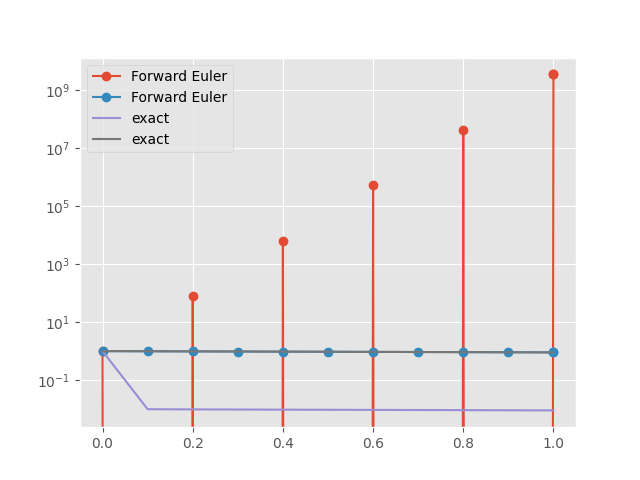

In [2]:
test = linear([[-100, 1], [0, -1/10]])

u_0 = numpy.asarray([1, 1])

def ode_euler(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    while t < T:
        h = min(h, T - t)
        u = u + h * f(t, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

thist, uhist = ode_euler(test, u_0, h=1/10, T=1)
pyplot.figure()

pyplot.semilogy(thist, uhist, "o", linestyle="solid", label='Forward Euler')
pyplot.semilogy(thist, test.exact(thist, u_0), label='exact');
pyplot.legend();

# Stability of timestepping schemes
### Observations

- When the timestep is very small, we get a reasonably accurate answer. 
- When the timestep gets big the numerical solution blows up.

# Stability of timestepping schemes
### Observations

- This is due to the small _stability domain_ of the explicit Euler method

- This constraint forces us to _artificially_ constrain the step size to avoid instabilities in the numerical solution.

- We will informally call these problems, where the timestep is small for stability, rather than accuracy, reasons *stiff*

### Questions

1. Show that the explicit Euler solution after $n$ steps of size $h$ can be written as
$$
u_n = (1 - 100h)^n x_1 + (1 - \frac{1}{10}h)^n x_2
$$
2. Use this to determine the appropriate maximum step size for the integration.
3. Confirm your analysis with some experiments

## An implicit method

Now let's consider the same problem, only this time we'll use backward Euler, an implicit method.

In [3]:
def ode_beuler(eqn, u_0, h=0.1, T=1):
    A = eqn.A
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    while t < T:
        h = min(h, T - t)
        # u <- (I - h A)^{-1} u
        u = numpy.linalg.solve(numpy.eye(len(A)) - h*A, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

<IPython.core.display.Javascript object>


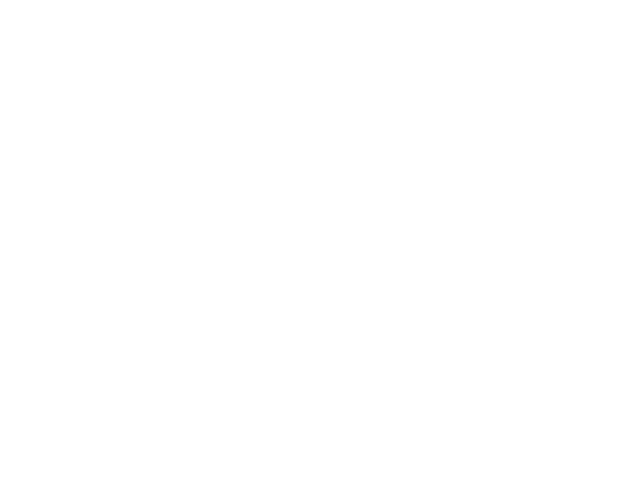

In [7]:
thist, uhist = ode_beuler(test, u_0, h=1, T=10)
pyplot.figure()

pyplot.semilogy(thist, uhist, "o", linestyle="solid", label='Backward Euler')
pyplot.semilogy(thist, test.exact(thist, u_0), label='exact');
pyplot.legend();

# Stability of timestepping schemes
### Observations

- Now we can take large timesteps, and only need to make $h$ small if we want higher accuracy.

# Why is this?



## Linear stability

Let's look at a scalar example: the *Dahlquist test equation*:

$$
\dot u = \lambda u \quad \lambda \in \mathbb{C}.
$$

When taking a step of length $h$, this equation has the exact solution

$$
u(h) = u_0 e^{\overbrace{\lambda h}^z} = u_0 e^{\mathfrak{R} z}(\cos \mathfrak{I} z + i\sin\mathfrak{I} z),
$$
where we wrote $\mathbb{C} \ni z = \lambda h$.


## Linear stability

When taking a step of length $h$, this equation has the exact solution

$$
u(h) = u_0 e^{\overbrace{\lambda h}^z} = u_0 e^{\mathfrak{R} z}(\cos \mathfrak{I} z + i\sin\mathfrak{I} z),
$$
where we wrote $\mathbb{C} \ni z = \lambda h$.

- This problem is _physically_ stable whenever the real part of $z$ (and hence $\lambda$) is less than zero: $\mathfrak{R} z \le 0$.

## Stability regions

Let us now consider applying the timestepping schemes we've already encountered to the test equation to see how they behave.


### Explicit Euler

$$
u(h) = u_0 +h f(u,t) = \underbrace{(1 + \lambda h)}_{R(z)}u_0.
$$


### Explicit Euler

Repeated application of the scheme results in:

$$
u(mh) = R(z)^m u_0.
$$

This scheme is convergent if as $m$ grows the right-hand side remains bounded, i.e. if and only if:

$$
|R(z)| \le 1.
$$

### Explicit Euler

So inserting the definition of $R(x)$
$$
|1+\lambda h| \le 1.
$$
This gives us a time-step restriction, we must choose $h$ so that the above equation holds.

# Let's run through the other schemes

### Implicit Euler

Performing a similar calculation we obtain

$$
R(z) = \frac{1}{1 - z}.
$$

# Let's run through the other schemes

### Trapezoidal rule/implicit midpoint

$$
R(z) = \frac{1 + z/2}{1 - z/2}.
$$


### Definitions
The function $R(z)$ is called the *stability function* of the method, the set

$$
S = \{ z \in \mathbb{C} \colon |R(z)| \le 1 \}
$$

is called the *stability domain*.

## Stability plots

Visualising the stability domains, by plotting $|R(z)|$ is an insightful way of comparing methods:

In [8]:
def plot_stability(x, y, R, label):
    pyplot.figure()
    C = pyplot.contourf(x, y, numpy.abs(R), numpy.linspace(0, 1, 10), cmap=pyplot.cm.coolwarm)
    
    pyplot.colorbar(C, ticks=numpy.linspace(0, 1, 10))
    pyplot.contour(x, y, numpy.abs(Rz), numpy.linspace(0, 1,4), colors='k')
    pyplot.xlabel("Re (z)")
    pyplot.ylabel("Im (z)")
    pyplot.title(label)

<IPython.core.display.Javascript object>


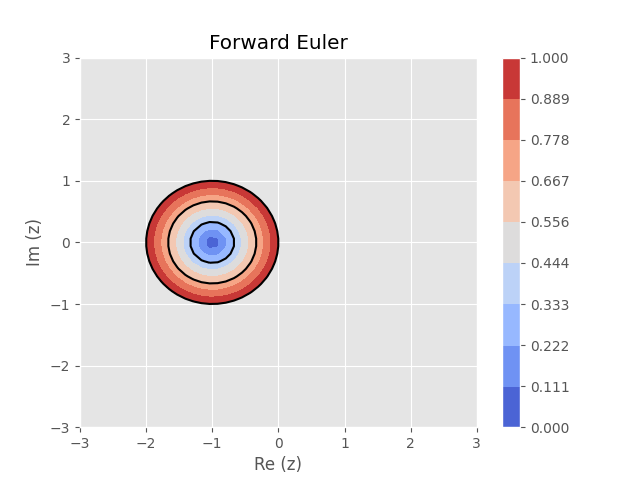

<IPython.core.display.Javascript object>


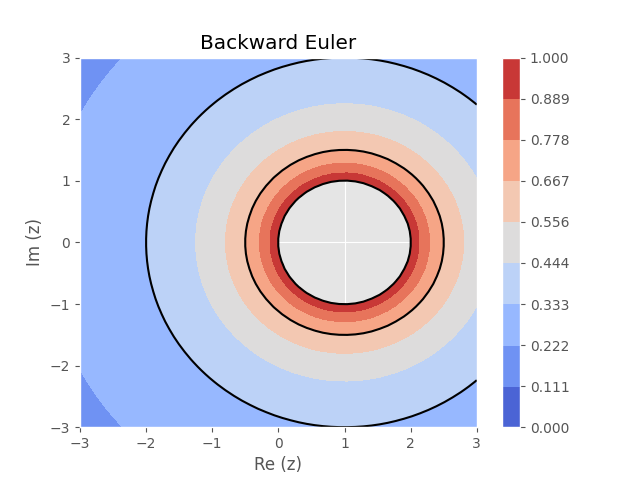

<IPython.core.display.Javascript object>


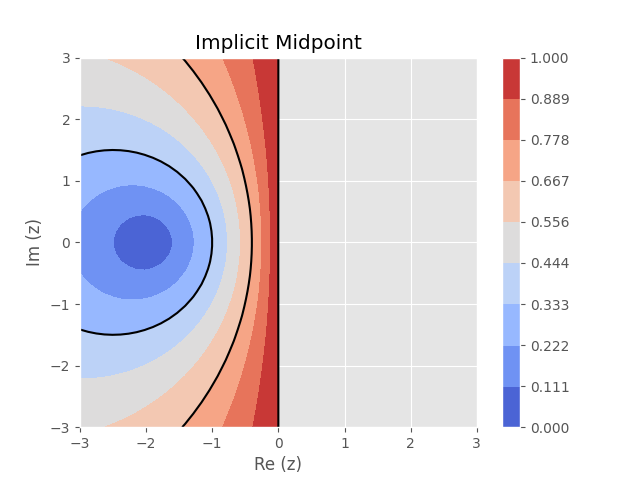

In [9]:
x = numpy.linspace(-3, 3)
x, y = numpy.meshgrid(x, x)
z = x + 1j*y

Rs = [("Forward Euler", 1 + z),
      ("Backward Euler", 1/(1 - z)),
      ("Implicit Midpoint", (1 + z/2)/(1 - z/2))]

for label, Rz in Rs:
    plot_stability(x, y, Rz, label)

## Definitions

### A-stability

A method is _A-stable_ if the stability domain

$$
S = \{z \in \mathbb{C} \colon |R(z)| \le 1\}
$$

contains the _entire_ left half plane

$$
\mathfrak{R} z \le 0.
$$

## Definitions

### A-stability

- This means that we can take arbitrarily large timesteps ($h \to \infty$) without the method becoming unstable (diverging) for any problem that is physically stable. 
    - Note that this says nothing about the _accuracy_ of the method.

- No explicit method is A-stable.



### A-stability

### Questions

1. Show that the midpoint method and implicit Euler really do contain the entire left half plane. Hint: multiply through by an appropriate choice of $1$, write $z = a + bi$ and show that $|R(z)| \le 1$ whenever $a \le 0$.

### Observations

While the physical problem is stable whenever $\mathfrak{R} \lambda \le 0$, the same is not true of all our methods. 

- The explicit Euler method is only stable in a small region of the left half plane, 
- implicit Euler is stable in the entire left half plane, and more, 
- implicit midpoint is stable in exactly the left half plane.

### A question naturally arises: Why would one ever use an explicit method? 
    - Can you think of any reasons?